# Hand-Gesture-Recognition-ASL
**Master degree's Computer-Vision course project:** Hand gesture recognition, translation from (ASL) american-sign-language to text. <br>
**By:** [Yehuda Yadid](https://www.linkedin.com/in/yehuda-yadid/) and [Eliran Shem Tov](https://www.linkedin.com/in/eliranshemtov/)
*****

## Summary
In this project we made 3 major attempts to train a neural network to successfully classify american sign language (ASL) images.
1. ### [ASL MNIST](https://www.kaggle.com/datamunge/sign-language-mnist)
    First we used the ASL MNIST dataset, to train a CNN model and achieved "amazing" results of almost 100% accuracy. <br> Unfortunately, this dataset is highly synthetic and is not close enough to real-world conditions. Therefore, we've made the next attempt. <br>
    The notebook that details this process [could be found here]() <br><br>
2. ### [ASL Alphabet](https://www.kaggle.com/grassknoted/asl-alphabet)
    Then, we tried to improve the results and train a model with a better dataset that would be closer to normal non-lab environments. We used the ASL Alphabet dataset which looks much more realistic and wide in range of angles. <br>
    Although this attempt yielded much better results, we still aimed to improve the model's fitting, so we turned to the third and final attempt. <br>
    The notebook that details this process [could be found here]() <br><br>
3. ### Tailormade wide-range videos
    Lastly we created a (slightly smaller) dataset, that was concluded by a set of videos of hand gestures from a wide set of angels. Each video was broken-down to a set frames which the model trained on. <br>
    The notebook you're exploring now details this process

*****

In [45]:
import os
import glob
import random
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import CSVLogger
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from typing import Tuple

# Load our impage processing module
import sys
from importlib import reload
sys.path.append('../')
import utils.img_processing as imp
reload(imp)

<module 'utils.img_processing' from '/home/notebook/../utils/img_processing.py'>

## Program Settings
Constants & Parameters

In [5]:
VERSION = "13"
TRAINED_MODEL_PATH = f"../resources/models/trained_model_{VERSION}.h5"
TRAINING_LOG_PATH = f"../resources/histories/training_{VERSION}.log"
DATASET_ASL_TRAIN_SET_PATH = "../resources/asl_data_set/asl_alphabet_train/asl_alphabet_train"
DATASET_ASL_TEST_SET_PATH = "../resources/asl_data_set/asl_alphabet_test/asl_alphabet_test"
DATASET_VIDEO_PATH = "../resources/videos"
CLASSES = "ABW"
SIZE = 128
TEST_VALIDATION_SETS_SIZE = 0.35
EPOCHS = 25
BATCH_SIZE = 50

# The new dataset
## Why?
After making the first two attempts which didn't leave us satisfied, we struggled with a new problem: The dataset is good for simple static images, but our world is 3D.<br>
So when we tried to test the trained model on images of our hands, we found that the model classieis images correctly, but under a limited set of conditions - the image has to be in a:
- ⚠️ certain angel
- ⚠️ lightning
- ⚠️ size
- ⚠️ position
- ⚠️ etc. 
When trying to classify frames taken from a video stream, the results were even worse. <br><br>

Therefore we chose to create a new data set, with a new idea.

## How?
After this journey, we finally understood that we need to create our own dataset that fits our needs:<br>
1. Real-world classification
2. Less affected by Z-axis rotation

We had some crazy ideas about how to create this dataset but we decided to run with a relatively simple approach: video-set .<br>
We captured videos of our hands presenting ASL character and most importantly the captured video presents a hand with some degree of Z-axis rotation.<br>
In addition, we created the same video with different backgrounds for a better training process.

### Example ASL character A background 0
<video controls src="../resources/videos/A_0.mp4">

### Example ASL character A background 1
<video controls src="../resources/videos/A_1.mp4">

### Example ASL character A background 2
<video controls src="../resources/videos/A_2.mp4">

### Example ASL character A background 3
<video controls src="../resources/videos/A_3.mp4">

## From video to frames
When the video was ready we wrote the following code to breakdown the video to frames.<br>
Now we have the real-world ASL dataset including Z axis rotation with little 3D support.<br>
<br>
Our model input requires square image in specific shape, so we need to crop every frame to fit this shape.<br>
Specifically we need the hand part inside the cropeed image.<br>
<br>
In order to detect hands in a given image we chose to use an external hands-recognition-model library, called [Mediapipe](https://github.com/google/mediapipe) which was developed by google. <br>
We kept the image aspect ratio, to achieve good prediction results.
Our approche is that the our model needs to learn the hand pose only and ignore all other noise<br>
So why do we need parts in the image without hands? we don't<br>
we crop the hand out from the image, resize it and insert the result into np matrix of **zeros** in the shape of the model input.<br>
<br>
In both phases (training and predicting), we crop the images and use the padding approach in the same manner. Therefore we have no reason to worry about having black padding noise in the image.

### Exmaple: Show the process on one video frame

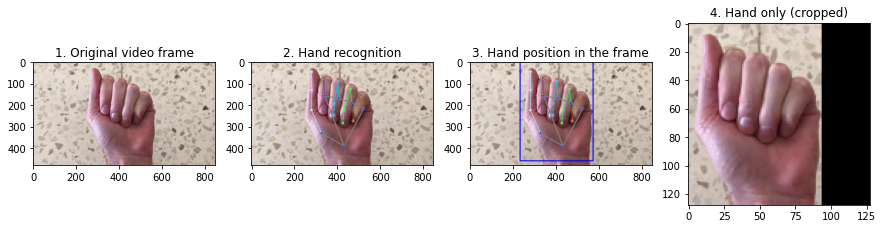

In [418]:
cap = cv.VideoCapture(DATASET_VIDEO_PATH + f"/A_1.mp4")
ex_original = None
ex_draw_hands = None
ex_draw_hands_frame = None
ex_cropped = None

while(cap.isOpened()):
    success, frame = cap.read()
    if not success:
        break

    hands = imp.recognize_hand_in_image(frame, should_flip_horizontal=False)
    hands_frame = imp.get_hand_frame(frame, hands)

    if hands_frame:
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

        ex_original = frame
        ex_draw_hands = imp.draw_hand(frame, hands)
        ex_draw_hands_frame = imp.draw_frame(ex_draw_hands, hands_frame[0], hands_frame[1], (0, 0, 255))
        ex_cropped = imp.crop_hand(frame, hands_frame[0], hands_frame[1], crop_size=SIZE).astype(np.uint8)

        break

plt.figure(figsize=(15, 15))
plt.subplot(1,4,1)
plt.title("1. Original video frame")
plt.imshow(ex_original)

plt.subplot(1,4,2)
plt.title("2. Hand recognition")
plt.imshow(ex_draw_hands)

plt.subplot(1,4,3)
plt.title("3. Hand position in the frame")
plt.imshow(ex_draw_hands_frame)

plt.subplot(1,4,4)
plt.title("4. Hand only (cropped)")
plt.imshow(ex_cropped)

cap.release()

## Dataset creation
Extract images from videos

In [383]:
def split_video_to_frame(input: str, output: str, crope_size: int = SIZE) -> None:
    print(f"Start splitting video {input} to frames")
    cap = cv.VideoCapture(input)
    i = 0

    while(cap.isOpened()):
        success, frame = cap.read()
        if not success:
            break

        hands = imp.recognize_hand_in_image(frame, should_flip_horizontal=False)
        hands_frame = imp.get_hand_frame(frame, hands)

        if hands_frame:
            cropped = imp.crop_hand(frame, hands_frame[0], hands_frame[1], crop_size=crope_size)
            cv.imwrite(output.format(i=i), cropped)
            print(f"Output: {output.format(i=i)}")
            i += 1

        if cv.waitKey(25) & 0xFF == ord('q'):
            break

    cap.release()
    print(f"End splitting video {input} to frames")

In [384]:
for i, c in enumerate(CLASSES):
    videos_list = glob.glob(DATASET_VIDEO_PATH + f"/{c}*.mp4")

    for j, source in enumerate(videos_list):
        split_video_to_frame(source, DATASET_VIDEO_PATH + "/" + str(c) +  "/{i}_" + str(j) + ".jpg")

Start splitting video ../resources/videos/A_3.mp4 to frames
Output: ../resources/videos/A/0_0.jpg
Output: ../resources/videos/A/1_0.jpg
Output: ../resources/videos/A/2_0.jpg
Output: ../resources/videos/A/3_0.jpg
Output: ../resources/videos/A/4_0.jpg
Output: ../resources/videos/A/5_0.jpg
Output: ../resources/videos/A/6_0.jpg
Output: ../resources/videos/A/7_0.jpg
Output: ../resources/videos/A/8_0.jpg
Output: ../resources/videos/A/9_0.jpg
Output: ../resources/videos/A/10_0.jpg
Output: ../resources/videos/A/11_0.jpg
Output: ../resources/videos/A/12_0.jpg
Output: ../resources/videos/A/13_0.jpg
Output: ../resources/videos/A/14_0.jpg
Output: ../resources/videos/A/15_0.jpg
Output: ../resources/videos/A/16_0.jpg
Output: ../resources/videos/A/17_0.jpg
Output: ../resources/videos/A/18_0.jpg
Output: ../resources/videos/A/19_0.jpg
Output: ../resources/videos/A/20_0.jpg
Output: ../resources/videos/A/21_0.jpg
Output: ../resources/videos/A/22_0.jpg
Output: ../resources/videos/A/23_0.jpg
Output: ../res

### Example results

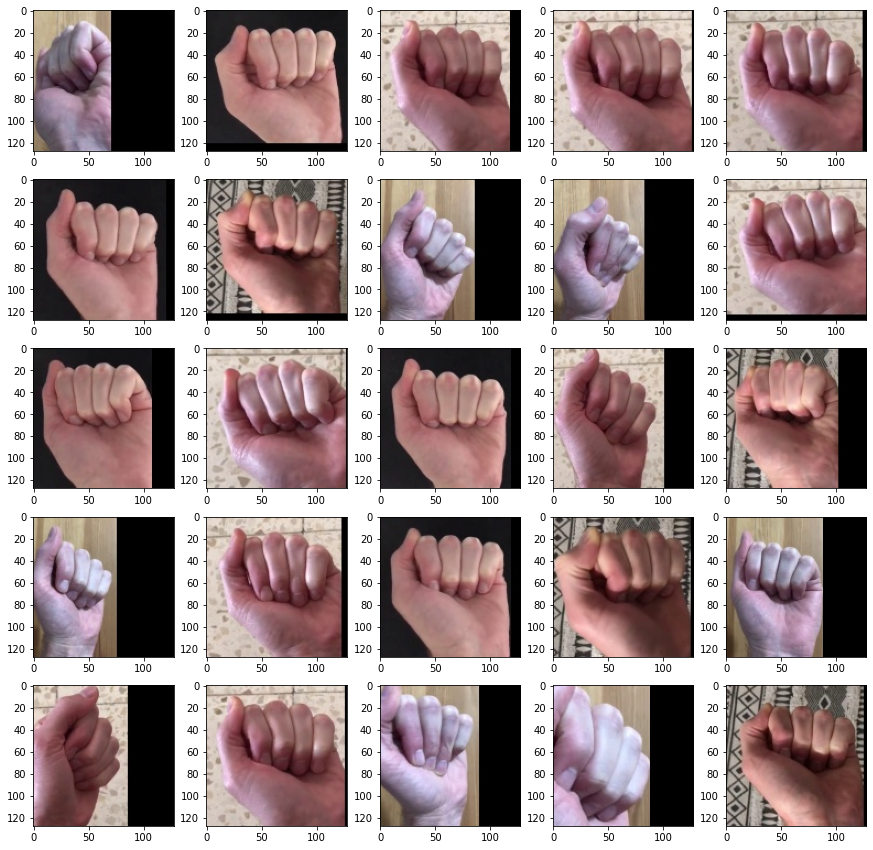

In [399]:
video_frames = glob.glob(f"{DATASET_VIDEO_PATH}/A/*.jpg")
random.shuffle(video_frames)

plt.figure(figsize=(15, 15))
for i, img in enumerate(video_frames[:25]):
    img = cv.imread(img)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)

## Dataset - Loading & Pre-Processing

### Loading

In [18]:
def load_dataset(path_format: str, classes: str = CLASSES, should_grayscale: bool = True) -> Tuple[list]:
    labels = []
    features = []

    for i, c in enumerate(classes):
        file_list = glob.glob(path_format.format(c=c))
        for item in file_list:
            grayscale_flag = cv.IMREAD_GRAYSCALE if should_grayscale else None
            img = cv.imread(item, grayscale_flag)
            features.append(img)
            labels.append(i)

    return features, labels

In [19]:
images, labels = load_dataset("../resources/videos/{c}/*.jpg")
print(f"Amount of dataset images: {len(images)}, labels: {len(labels)}")

Amount of dataset images: 10483, labels: 10483


### Pre-processing
1. resize image if needed to the model's input shape
2. convert the image to grayscale if needed.
3. normalize the image to improve training process. <br>
    CNN are known to converges faster and better on normalized data <br>
    at scale of [0..1] (than on [0..255]).

In [20]:
def pre_processing_img(img: np.ndarray, size: int = SIZE, should_grayscale: bool = False, resize: bool = True) -> np.ndarray:
    img = img.copy()
    if resize:
        img = cv.resize(img, (size, size))
    if should_grayscale:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return img.astype(np.uint8) / 255

In [21]:
def pre_proccessing_dataset(features: list, labels: list, size: int = SIZE, should_grayscale: bool = False, resize: bool = True) -> Tuple[np.ndarray]:
    train_values = []
    train_labels = []

    for f in features:
        train_values.append(pre_processing_img(f, size, should_grayscale, resize))

    for l in labels:
        train_labels.append(l)

    return train_values, train_labels

In [22]:
images, labels = pre_proccessing_dataset(images, labels)

## Label Binarization
Here we binarize lables in a one-vs-all fasion. 
#### What does it mean?
We convert our labels to classes in a binary manner. <br> 
That means that every label is switched from a single-value-label to a set of binary labels. <br>
**For example:** "3" is turned into: (0,0,0,**1**,0,0,0,0,0...)

In [23]:
def serialize_labels(labels: list) -> np.ndarray:
    label_binarizer = LabelBinarizer()
    return label_binarizer.fit_transform(labels)

#### Example

In [24]:
ex_labels = labels.copy()
before = ex_labels[0]

ex_labels = serialize_labels(ex_labels)
after = ex_labels[0]
print(f"Before binarizer: {before}, after: {after}")

Before binarizer: 0, after: [1 0 0]


In [25]:
labels = serialize_labels(labels)

In [26]:
def serialize_images(images: list, size: int = SIZE) -> np.ndarray:
    return np.array(images).reshape(-1, SIZE, SIZE, 1)

In [27]:
images = serialize_images(images)

## Train & Validation & Test split
We split the dataset to training-set (75% of the data), validation-set (17.5%) and test-set (17.5%)

In [28]:
train_values, validation_test_values, train_labels, validation_test_labels = train_test_split(images, labels, test_size=TEST_VALIDATION_SETS_SIZE)
validation_values, test_values, validation_labels, test_labels = train_test_split(validation_test_values, validation_test_labels, test_size=0.5)

print("Train data : ",len(train_values),len(train_labels))
print("Validation data : ",len(validation_values),len(validation_labels))
print("Test data : ",len(test_values),len(test_labels))

Train data :  6813 6813
Validation data :  1835 1835
Test data :  1835 1835


## Data augmentation using keras.

1. Accepting a batch of images used for training.
2. Taking this batch and applying a series of random transformations to each image in the batch (including random rotation, resizing, shearing, etc.).
3. **Replacing the original batch** with the new, randomly transformed batch.
4. Training the CNN on this randomly transformed batch (i.e., the original data itself is not used for training).

*data augmentation illustration*<br>
<img src="https://www.pyimagesearch.com/wp-content/uploads/2019/07/keras_data_augmentation_header.png" alt="data-augmentation" width="250"/>

In [29]:
def create_data_augmentation(features):
    datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.2, # Randomly zoom image 
            width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
    datagen.fit(features)
    return datagen

In [30]:
datagen = create_data_augmentation(train_values)

## CNN Model
Convolutional Neural Network are a huge subject to discuss hours about.<br>
Shortly, CNN is a deep learning algorithm which takes-in inputs, assigned with a label and learns to extract the most significant features from the input, and classify them based on the already trained-on weights (created by a long training process of iterating training-set inputs over the network's layers). <br>
Since this topic could not be fully covered here, we won't get to the things depth in this notebook.
<br><br><br>
<img src="https://miro.medium.com/max/2000/1*vkQ0hXDaQv57sALXAJquxA.jpeg" alt="data-augmentation"/><br>
<small>Source: https://miro.medium.com/max/2000/1*vkQ0hXDaQv57sALXAJquxA.jpeg </small> 
<br><br>
The model-layer's structure was influenced by [this article](https://miro.medium.com/max/2000/1*vkQ0hXDaQv57sALXAJquxA.jpeg) and a lot web research.

In [32]:
def create_model(input_shape: Tuple[int] = (SIZE, SIZE, 1) ,units: int = len(CLASSES)) -> Model:
    model = Sequential()
    model.add(Conv2D(32 , (3,3), activation = 'relu' , input_shape = input_shape))
    model.add(Conv2D(32 , (3,3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2))
    
    model.add(Flatten())
    model.add(Dense(units = 512 , activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = units , activation = 'softmax'))
    
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    return model

We trained the model on a strong server, so we wrote here the code for training but<br>
currently we load the trained model and model's history from disc

In [33]:
def is_model_exists(path: str = TRAINED_MODEL_PATH):
    return os.path.exists(TRAINED_MODEL_PATH)

In [35]:
if is_model_exists():
    print("Trained model loaded from the disc")
    model = load_model(TRAINED_MODEL_PATH)
else:
    print("Created new model")
    model = create_model()


model.summary()

Created new model
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 124, 124, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 58, 58, 64)        36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 

## Model callbackes

### ReduceLROnPlateau
Reduce learning rate when a metric has stopped improving.

In [36]:
def learning_rate_reduction_callback():
    return ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

### CSVLogger
To persist the model's training log history

In [37]:
def csv_logger_callback(path: str = TRAINING_LOG_PATH):
    return CSVLogger(path, separator=',', append=False)

## Model training

In [38]:
def model_training(model: Model, datagen: ImageDataGenerator, train: Tuple[np.ndarray], validations: Tuple[np.ndarray], epochs: int = EPOCHS, batch_size: int = BATCH_SIZE, trained_model_path: str = TRAINED_MODEL_PATH) -> dict:
    callbacks = [learning_rate_reduction_callback(), csv_logger_callback()]
    history = model.fit(datagen.flow(train[0], train[1], batch_size = batch_size) ,epochs = epochs , validation_data = validations , callbacks = callbacks)
    model.save(trained_model_path)

    return history.history

In [39]:
def load_model_history(path: str = TRAINING_LOG_PATH) -> dict:
    return pd.read_csv(path, sep=',', engine='python')

In [40]:
if is_model_exists():
    print("Load history from the disc")
    history = load_model_history()
else:
    print("Start to train the model")
    history = model_training(model, datagen, train=(train_values, train_labels), validations=(validation_values, validation_labels))

Start to train the model


2021-08-29 17:09:00.879877: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
137/137 [==============================] - 163s 1s/step - loss: 5.0346 - accuracy: 0.6695 - val_loss: 62.5823 - val_accuracy: 0.3199
Epoch 2/25
137/137 [==============================] - 162s 1s/step - loss: 0.6888 - accuracy: 0.7919 - val_loss: 96.9944 - val_accuracy: 0.3199
Epoch 3/25
137/137 [==============================] - 162s 1s/step - loss: 0.4316 - accuracy: 0.8476 - val_loss: 65.5201 - val_accuracy: 0.3199

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/25
137/137 [==============================] - 162s 1s/step - loss: 0.2477 - accuracy: 0.9071 - val_loss: 17.4674 - val_accuracy: 0.6262
Epoch 5/25
137/137 [==============================] - 163s 1s/step - loss: 0.2272 - accuracy: 0.9229 - val_loss: 0.1470 - val_accuracy: 0.9597
Epoch 6/25
137/137 [==============================] - 162s 1s/step - loss: 0.1992 - accuracy: 0.9312 - val_loss: 0.0286 - val_accuracy: 0.9891
Epoch 7/25
137/137 [==============================] - 162

# Results

## Overfitting validation
Overfitting occurs when a model fits exactly against its training set. When this happens, the algorithm unfortunately cannot perform accurately against new data from outside of the training set, defeating its purpose. <br>

When the model memorizes the noise and fits too closely to the training set, the model becomes “overfitted,” and it is unable to generalize well to new data.

Low error rates and a high variance are good indicators of overfitting. In order to prevent this type of behavior, part of the training dataset is typically set aside as the “validataion set” to check for overfitting. If the training data has a low error rate and the validation data has a high error rate, it signals overfitting.


<img src="https://1.cms.s81c.com/sites/default/files/2021-03-03/classic%20overfitting_0.jpg" alt="data-augmentation" width="400"/>
<br><br>
<small>Source: https://www.ibm.com/cloud/learn/overfitting</small>



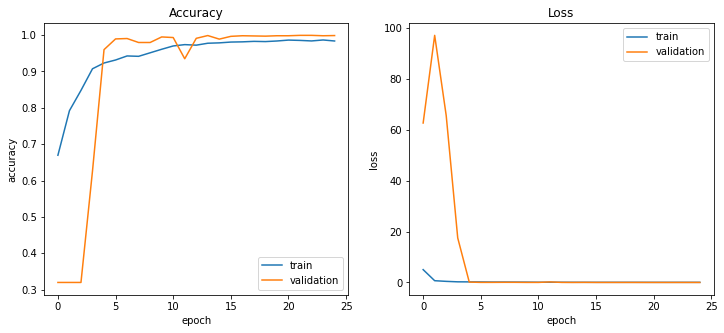

In [41]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','validation'])

plt.subplot(1,2,2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','validation'])


plt.show()

## Model Evaluation
When evaluating the model we run it against the test set; a group of images that the model have never seen before. <br>
*Note: the test set was taken from the same source as the training and validation sets, and therefore might show high accuracy.

In [43]:
def model_evaluation(model: Model, test: Tuple[np.ndarray]) -> int:
    return model.evaluate(test[0], test[1])[1]*100

In [44]:
model_evaluation(model, (test_values, test_labels))

58/58 [==============================] - 7s 117ms/step - loss: 0.0247 - accuracy: 0.9978


99.78201389312744